## Import libraries

In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import pandas as pd
import geopandas as gpd

## Load data

In [2]:
gdp = pd.read_csv('data/regions_gdp.csv', encoding = "ISO-8859-1")

# Remove space in Value
gdp['Value'] = gdp['Value'].apply(lambda x: x.replace(' ', ''))
gdp['Value'] = pd.to_numeric(gdp['Value'])

# Merge Bolzano and Trento
for year in gdp['TIME'].unique():
    bolzano = gdp.loc[(gdp['GEO'] == 'Provincia Autonoma di Bolzano/Bozen') & (gdp['TIME'] == year)]['Value']
    trento = gdp.loc[(gdp['GEO'] == 'Provincia Autonoma di Trento') & (gdp['TIME'] == year)]['Value']
    sum_trento_bolzano = bolzano.item() + trento.item()
    gdp.loc[(gdp['GEO'] == 'Provincia Autonoma di Trento') & (gdp['TIME'] == year), 'Value'] = sum_trento_bolzano
    gdp.loc[(gdp['GEO'] == 'Provincia Autonoma di Trento') & (gdp['TIME'] == year), 'GEO'] = 'Trentino Alto Adige'
    gdp = gdp.loc[~((gdp['GEO'] == 'Provincia Autonoma di Bolzano/Bozen') & (gdp['TIME'] == year)),:]

gdp.loc[(gdp['GEO'] == 'Valle d\'Aosta/Vallée d\'Aoste'), 'GEO'] = 'Valle d\'Aosta / Vallée d\'Aoste'

gdp.head(10)

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: `item` has been deprecated and will be removed in a future version
  # This is added back by InteractiveShellApp.init_path()


,TIME,GEO,UNIT,Value
0,2010,Piemonte,Million euro,124550.57
1,2010,Valle d'Aosta / Vallée d'Aoste,Million euro,4737.80
2,2010,Liguria,Million euro,46095.02
3,2010,Lombardia,Million euro,349558.17
5,2010,Trentino Alto Adige,Million euro,38393.08
6,2010,Veneto,Million euro,143256.75
7,2010,Friuli-Venezia Giulia,Million euro,34916.35
8,2010,Emilia-Romagna,Million euro,137950.00
9,2010,Toscana,Million euro,105269.65
10,2010,Umbria,Million euro,22180.13


In [3]:
df = pd.read_csv('data/public_auth_interactions.csv')
df.drop(['ITTER107', 'TIPO_DATO_SDS_ICT', 'Select time', 'Flag Codes', 'Flags'], axis=1, inplace=True)

# Delete rows with year = 2019, since we do not have the GDP data for that year
df = df.loc[~(df['TIME'] == 2019),:]

# Merge Bolzano, Trento and Sudtirol
for year in df['TIME'].unique():
    for data_type in df['Data type'].unique():
        sudtirol_exp = df.loc[(df['Territory'] == 'Trentino Alto Adige / Südtirol') & (df['TIME'] == year) & (df['Data type'] == data_type)]['Value']
        bolzano_exp = df.loc[(df['Territory'] == 'Provincia Autonoma Bolzano / Bozen') & (df['TIME'] == year) & (df['Data type'] == data_type)]['Value']
        trento_exp = df.loc[(df['Territory'] == 'Provincia Autonoma Trento') & (df['TIME'] == year) & (df['Data type'] == data_type)]['Value']
        avg_exp = (float(sudtirol_exp.item()) + float(bolzano_exp.item()) + float(trento_exp.item())) / 3
        df.loc[(df['Territory'] == 'Trentino Alto Adige / Südtirol') & (df['TIME'] == year) & (df['Data type'] == data_type), 'Value'] = avg_exp
        df.loc[(df['Territory'] == 'Trentino Alto Adige / Südtirol') & (df['TIME'] == year) & (df['Data type'] == data_type), 'Territory'] = 'Trentino Alto Adige'
        df = df.loc[~(((df['Territory'] == 'Provincia Autonoma Bolzano / Bozen')) & (df['TIME'] == year) & (df['Data type'] == data_type)),:]
        df = df.loc[~(((df['Territory'] == 'Provincia Autonoma Trento')) & (df['TIME'] == year) & (df['Data type'] == data_type)),:]

df.head()

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: `item` has been deprecated and will be removed in a future version
  del sys.path[0]


,Territory,Data type,TIME,Value
0,Piemonte,obtaining information,2010,37.0
1,Piemonte,obtaining information,2011,40.0
2,Piemonte,obtaining information,2012,30.3
3,Piemonte,obtaining information,2013,26.1
4,Piemonte,obtaining information,2014,32.4


## Compute the surprise data

In [4]:
surprise_data = []
for index, region in enumerate(df['Territory'].unique()):
    surprise_data.append([])
    for _ in range(len(df['TIME'].unique())): # 10 
        surprise_data[index].append(0)

In [5]:
surprise_data

[[0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0]]

Start with equiprobably P(M)s

For each year:

- Calculate observed-expected
- Estimate P(D|M)
- Estimate P(M|D)
- Surprise is D_KL ( P(M|D) || P(M) )
- Normalize so sum P(M)s = 1

For now, let's use only one model. We have to include inside our prior the economic status of the regions: an idea could be to take the GDP of each region and assume that the higher the GDP the higher the interaction with the public authorities. More precisely, we can assume that the highest GDP will correspond to the highest rate of interaction, and so on...

In [6]:
# Since we have only one model...
pM = 1

# FOR NOW LET'S FOCUS ONLY ON THE 'OBTAINING INFORMATION' INTERACTION

for k, year in enumerate(df['TIME'].unique()):
    # Compute the average rate of the current year
    avg_rate = np.mean(df.loc[(df['TIME'] == year) & (df['Data type'] == 'obtaining information')]['Value'])
    # Compute the sum of the rates of the current year
    sum_rate = np.sum(df.loc[(df['TIME'] == year) & (df['Data type'] == 'obtaining information')]['Value'])
    
    # Get the list of regions ordered by GDP of the current year
    current_gdp = gdp.loc[gdp['TIME'] == year].sort_values(by=['Value'], ascending=False)
    
    for j, region in enumerate(df['Territory'].unique()):
        # Estimate P(D|M) as 1 - |O - E|
        O = (df.loc[(df['TIME'] == year) & (df['Territory'] == region) & (df['Data type'] == 'obtaining information')]['Value'] / sum_rate).item()
        # Get the region with the highest GDP in the current year
        highest_gdp = gdp.loc[gdp['TIME'] == year].max()['GEO']
        # Get the index of the current region in the ordered GDP list
        index = list(current_gdp['GEO']).index(region)
        # Get the current data observed and sort them
        obs_data = df.loc[(df['TIME'] == year) & (df['Data type'] == 'obtaining information')]
        obs_data.sort_values(by=['Value'], ascending=False, inplace=True)
        # Get the expected value
        E = (obs_data.iloc[index]['Value'] / sum_rate).item()
        
        # P(D|M)
        pDM = 1 - np.abs(O - E)
        
        # Estimate P(M|D)
        pMD = pDM * pM
        
        # Surprise is the sum of KL divergance across model space (only one here)
        kl = pMD * (np.log(pMD / pM) / np.log(2))
        surprise_data[j][k] = np.abs(kl) if (O - E) > 0 else -np.abs(kl)
        
    # Now let's globally update our model belief
    pDM = 1 - (0.5 * np.abs(O - E))
    pMD = pDM * pM
    pM = pMD

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: `item` has been deprecated and will be removed in a future version
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## Plot the result

In [7]:
# Starting from the surprise data, create a dataframe
df_structure = {}
for region in df['Territory'].unique():
    df_structure[region] = []
for index, region in enumerate(df_structure):
    df_structure[region] = surprise_data[index]

surprise_df = pd.DataFrame(df_structure).transpose()
surprise_df.index.name = 'Territory'
surprise_df.columns = [str(year) for year in df['TIME'].unique()]

In [8]:
surprise_df.head(20)

,2010,2011,2012,2013,2014,2015,2016,2017,2018
Territory,,,,,,,,,
Piemonte,-0.008686,-0.000000,-0.000756,-0.016268,-0.000477,0.000649,0.003153,-0.007145,-0.010077
Valle d'Aosta / Vallée d'Aoste,0.024784,0.035000,0.035091,0.027665,0.018722,0.034154,0.044762,0.029598,0.025881
Liguria,-0.003216,-0.011288,-0.009545,-0.008283,-0.009511,-0.000000,-0.004465,0.000272,-0.000562
Lombardia,-0.008498,-0.014759,-0.023742,-0.008033,-0.009748,-0.008498,-0.016994,-0.008947,-0.003647
Trentino Alto Adige,0.012071,0.018831,0.013712,0.010200,0.012352,0.011480,0.016648,0.006603,0.009054
Veneto,-0.010380,-0.010470,-0.006705,0.000839,-0.007851,-0.005833,-0.003940,-0.000000,-0.007379
Friuli-Venezia Giulia,0.012259,0.022891,0.024980,0.024701,0.016366,0.015259,0.017774,0.016762,0.003647
Emilia-Romagna,-0.013010,-0.012105,-0.005785,-0.007532,-0.011642,-0.007772,-0.011005,0.005159,0.000562
Toscana,-0.001136,-0.003293,-0.005534,-0.002012,0.007614,-0.000000,-0.000000,-0.000000,0.003647


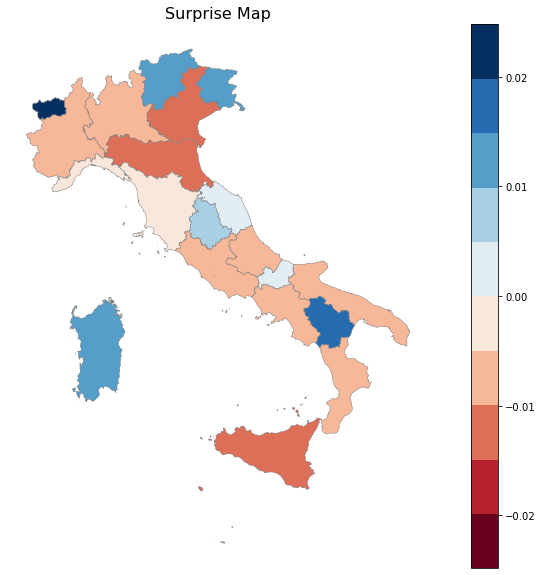

In [9]:
map_reg = gpd.read_file(os.path.join('..', 'assets', 'maps', 'Reg01012019_g', 'Reg01012019_g_WGS84.shp'))
map_reg['DEN_REG'] = map_reg['DEN_REG'].replace({'Friuli Venezia Giulia': 'Friuli-Venezia Giulia', 'Trentino-Alto Adige': 'Trentino Alto Adige', "Valle d'Aosta": "Valle d'Aosta / Vallée d'Aoste"})
# Merge the map with the pandas df
merged = pd.merge(map_reg, surprise_df, left_on='DEN_REG', right_on='Territory', how='left')

YEAR = '2010'
fig, ax = plt.subplots(1, figsize=(15, 10))
ax.axis('off')
ax.set_title('Surprise Map', fontsize=16)
cmap = plt.get_cmap('RdBu', 10)
max_abs_value = max(np.abs(min(merged[YEAR])), np.abs(max(merged[YEAR])))
merged.plot(column=YEAR, vmin = -max_abs_value, vmax = max_abs_value, cmap=cmap, linewidth=0.5, ax=ax, edgecolor='0.5', legend=True)

## Next steps...
- Apply the same code to the other two 'data types' (downloading official forms, submitting completed forms);
- The visualization above refers to only one year (2010). Use a slider to visualize the change over time.
- Apply the same methodology to other datasets, e.g. the 'online purchase' one.